In [ ]:
# Need to write a translator from German to English using IWSLT 2016 de-en dataset

## DOWNLOAD DATASET

In [ ]:
!mkdir -p /root/.kaggle
# from google.colab import drive
# drive.mount('/content/gdrive')

api_token = {"username":"<your-kaggle-username>","key":"<your-kaggle-token>"}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tttzof351/iwslt-2016-de-en
!unzip -qq iwslt-2016-de-en.zip
!rm -r iwslt-2016-de-en.zip
!rm -r sample_data

 82% 12.0M/14.6M [00:01<00:00, 12.4MB/s]
100% 14.6M/14.6M [00:01<00:00, 8.13MB/s]


## SEED

In [ ]:
import os
import numpy as np
import codecs
import regex
import json

import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split

In [ ]:
SEED = 1

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## DATA

In [ ]:
def get_samples(file):
  text = codecs.open(file, 'r', 'utf-8').read().lower()
  text = regex.sub("<.*>.*</.*>\r\n", "", text)
  text = regex.sub("[^\n\s\p{Latin}']", "", text)
  samples = text.split('\n')
  return samples

In [ ]:
de_samples = get_samples("data/train.tags.de-en.de")
en_samples = get_samples("data/train.tags.de-en.en")

assert len(de_samples) == len(en_samples)

en_words = json.load(open("data/en_dict.json", 'r', encoding='utf-8'))
de_words = json.load(open("data/de_dict.json", 'r', encoding='utf-8'))

en_to_id = { word: i for i, word in enumerate(en_words) }
de_to_id = { word: i for i, word in enumerate(de_words) }

id_to_en = { id: word for word, id in en_to_id.items() }
id_to_de = { id: word for word, id in de_to_id.items() }

DE_VOC_SIZE = len(de_words)
EN_VOC_SIZE = len(en_words)

MAX_SEQ_SIZE = max(
  max([len(s) for s in de_samples]),
  max([len(s) for s in en_samples]),
)

In [ ]:
print(id_to_en[0], id_to_en[1], id_to_en[2], id_to_en[3])
print(id_to_de[0], id_to_de[1], id_to_de[2], id_to_de[3])
print(en_samples[10])
print(de_samples[10])

<PAD> <UNK> <START> <END>
<PAD> <UNK> <START> <END>
and the problem i think is that we take the ocean for granted
ich denke das problem ist dass wir das meer für zu selbstverständlich halten


In [ ]:
MAX_SEQ_SIZE

2962

## UTILS

In [ ]:
def mask_from_seq_lengths(
    sequence_lengths: torch.Tensor,
    max_length: int
) -> torch.BoolTensor:
    """
    our input was `[2, 2, 3]`, with a `max_length` of 4, we'd return
    `[[1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0]]`.
    """
    # (batch_size, max_length)
    ones = sequence_lengths.new_ones(sequence_lengths.size(0), max_length)
    range_tensor = ones.cumsum(dim=1)
    return sequence_lengths.unsqueeze(1) >= range_tensor

In [ ]:
def shift_right(
    input, # [N, L]
    sos
):
  N = input.shape[0]
  return torch.cat([
    torch.full((N, 1), sos, device=input.device),
    input[:, :-1]
  ], dim=1)

In [ ]:
def to_cuda(batch):
  return [it.cuda() for it in batch]

## DATASET & DATALOADER

In [ ]:
class TranslationDataset(torch.utils.data.Dataset):
  def __init__(self, indexes: list):
      self.indexes = indexes
      self.en_unk = en_to_id["<UNK>"]
      self.de_unk = de_to_id["<UNK>"]

      self.en_end = en_to_id["<END>"]
      self.de_end = de_to_id["<END>"]

      self.cache = {}

  def __getitem__(self, index):
    cache_value = self.cache.get(index, None)
    if cache_value is not None:
      de_ids, en_ids = cache_value
    else:
      de_ids, en_ids = self.get_item(index)
      self.cache[index] = (de_ids, en_ids)

    return de_ids, en_ids

  def get_item(self, index):
    i = self.indexes[index]
    en_sentence = en_samples[i]
    de_sentence = de_samples[i]

    en_ids = []
    for token in en_sentence.split():
      en_id = en_to_id.get(token, self.en_unk)
      en_ids.append(en_id)
    en_ids.append(self.en_end)

    de_ids = []
    for token in de_sentence.split():
      de_id = de_to_id.get(token, self.de_unk)
      de_ids.append(de_id)
    de_ids.append(self.de_end)

    en_ids = torch.Tensor(en_ids).long()
    de_ids = torch.Tensor(de_ids).long()

    return de_ids, en_ids

  def __len__(self):
    return len(self.indexes)

In [ ]:
def text_collate_fn(batch):
  de_length_max = torch.tensor(
    [de.shape[-1] for de, _ in batch],
    dtype=torch.int32
  ).max()

  en_length_max = torch.tensor(
    [en.shape[-1] for _, en in batch],
    dtype=torch.int32
  ).max()

  en_pad = en_to_id["<PAD>"]
  de_pad = de_to_id["<PAD>"]

  de_lengths = []
  de_padded = []

  en_lengths = []
  en_padded = []

  for de_text, en_text in batch:
    de_length = de_text.shape[-1]
    de_text = torch.nn.functional.pad(
      de_text,
      pad=[0, de_length_max - de_length],
      value=de_pad
    )
    de_padded.append(de_text)
    de_lengths.append(de_length)

    en_length = en_text.shape[-1]
    en_text = torch.nn.functional.pad(
      en_text,
      pad=[0, en_length_max - en_length],
      value=en_pad
    )
    en_padded.append(en_text)
    en_lengths.append(en_length)

  de_lengths = torch.Tensor(de_lengths).long()
  de_padded = torch.stack(de_padded)

  en_lengths = torch.Tensor(en_lengths).long()
  en_padded = torch.stack(en_padded)

  return de_padded, \
         de_lengths, \
         en_padded, \
         en_lengths

In [ ]:
loader = torch.utils.data.DataLoader(
    dataset=TranslationDataset(range(10)),
    num_workers=0,
    shuffle=True,
    sampler=None,
    batch_size=32,
    pin_memory=True,
    drop_last=False,
    collate_fn=text_collate_fn
)

for de_padded, de_lengths, en_padded, en_lengths in loader:
  print("de_padded:", de_padded.shape)
  print("de_lengths:", de_lengths.shape)

  print("en_padded:", en_padded.shape)
  print("en_lengths:", en_lengths.shape)
  break

de_padded: torch.Size([10, 49])
de_lengths: torch.Size([10])
en_padded: torch.Size([10, 45])
en_lengths: torch.Size([10])


## MODEL

In [ ]:
E_hidden = 128
E_x = DE_VOC_SIZE
E_y = EN_VOC_SIZE

class EncoderBlock(nn.Module):
  def __init__(self):
    super(EncoderBlock, self).__init__()
    self.self_att = torch.nn.MultiheadAttention(
        embed_dim = E_hidden,
        num_heads = 4,
        batch_first=True
    )
    self.norm_1 = nn.LayerNorm(E_hidden)
    self.dense_1 = nn.Linear(E_hidden, E_hidden)
    self.dense_2 = nn.Linear(E_hidden, E_hidden)
    self.norm_2 = nn.LayerNorm(E_hidden)

  def forward(
      self,
      x, # [N, S, E_hidden]
      x_key_padding_mask, # [N, S]
  ):
    x_tmp = self.norm_1(x) # [N, S, E_hidden]
    x_tmp, _ = self.self_att(
        query=x_tmp,
        key=x_tmp,
        value=x_tmp,
        key_padding_mask=x_key_padding_mask

    ) # [N, S, E_hidden]
    x = x + x_tmp # [N, S, E_hidden]

    x_tmp = self.norm_2(x) # [N, S, E_hidden]
    x_tmp = self.dense_1(x_tmp) # [N, S, E_hidden]
    x_tmp = F.relu(x_tmp) # [N, S, E_hidden]
    x_tmp = self.dense_2(x_tmp) # [N, S, E_hidden]
    x = x + x_tmp # [N, S, E_hidden]

    return x


class DecoderBlock(nn.Module):
  def __init__(self):
    super(DecoderBlock, self).__init__()
    self.self_att = torch.nn.MultiheadAttention(
        embed_dim = E_hidden,
        num_heads = 4,
        batch_first=True
    )
    self.norm_1 = nn.LayerNorm(E_hidden)

    self.cross_att = torch.nn.MultiheadAttention(
        embed_dim = E_hidden,
        num_heads = 4,
        batch_first=True
    )

    self.dense_1 = nn.Linear(E_hidden, E_hidden)
    self.dense_2 = nn.Linear(E_hidden, E_hidden)

    self.norm_2 = nn.LayerNorm(E_hidden)
    self.norm_3 = nn.LayerNorm(E_hidden)

  def forward(
      self,
      x, # [N, S, E_hidden]
      y,  # [N, L, E_hidden],
      x_key_padding_mask, # [N, S],
      y_key_padding_mask, # [N, L],
      memory_mask, # [L, S]
  ):

    # Pay attention: mixed q1/q2/q3 !
    y_tmp = self.norm_1(y) # [N, L, E_hidden]
    y_tmp, _ = self.self_att(
        query=y_tmp,
        key=y_tmp,
        value=y_tmp,
        attn_mask=memory_mask,
        key_padding_mask=y_key_padding_mask

    ) # [N, L, E_hidden]
    y = y + y_tmp # [N, L, E_hidden]

    y_tmp = self.norm_2(y) # [N, L, E_hidden]
    y_tmp, cross_att_weights = self.cross_att(
        query=y_tmp,
        key=x,
        value=x,
        key_padding_mask=x_key_padding_mask
    ) # [N, L, E_hidden]
    y = y + y_tmp # [N, L, E_hidden]

    y_tmp = self.norm_3(y) # [N, L, E_hidden]
    y_tmp = self.dense_1(y_tmp) # [N, L, E_hidden]
    y_tmp = F.relu(y_tmp) # [N, L, E_hidden]
    y_tmp = self.dense_1(y_tmp) # [N, L, E_hidden]
    y = y + y_tmp # [N, L, E_hidden]

    return y, cross_att_weights


class EmbeddingBlock(nn.Module):
  def __init__(self):
    super(EmbeddingBlock, self).__init__()
    self.x_emb = nn.Embedding(
        num_embeddings=E_x,
        embedding_dim=E_hidden
    )

    self.y_emb = nn.Embedding(
        num_embeddings=E_y,
        embedding_dim=E_hidden
    )

  def forward(
      self,
      x, # [N, S]
      y  # [N, L]
  ):
    x = self.x_emb(x)
    y = self.y_emb(y)
    return x, y

class TransformerModel(nn.Module):
  def __init__(self):
    super(TransformerModel, self).__init__()

    self.emb_block = EmbeddingBlock()

    self.x_pos_enc_emb = nn.Embedding(
      num_embeddings=MAX_SEQ_SIZE,
      embedding_dim=E_hidden
    )

    self.y_pos_enc_emb = nn.Embedding(
      num_embeddings=MAX_SEQ_SIZE,
      embedding_dim=E_hidden
    )

    self.encoder_1 = EncoderBlock()
    self.encoder_2 = EncoderBlock()
    self.encoder_3 = EncoderBlock()


    self.decoder_1 = DecoderBlock()
    self.decoder_2 = DecoderBlock()
    self.decoder_3 = DecoderBlock()

    self.final_dense = nn.Linear(E_hidden, E_y)

  def forward(
      self,
      x, # [N, S],
      x_lengths, # [N]
      y,  # [N, L]
      y_lengths, # [N]
  ):
    x, y = self.emb_block(x, y) # [N, S, E_hidden], [N, L, E_hidden]

    x_pos_enc = self.x_pos_enc_emb(
        torch.arange(0, x.shape[1], device=x.device).long()
    ) # [S, E_hidden]
    x = x + x_pos_enc

    y_pos_enc = self.y_pos_enc_emb(
        torch.arange(0, y.shape[1], device=x.device).long()
    ) # [L, E_hidden]
    y = y + y_pos_enc


    #### Masks ####
    N = x.shape[0]
    S = x.shape[1]
    L = y.shape[1]

    x_key_padding_mask = torch.zeros(
        (N, S),
        device=x.device
    ).masked_fill(
      mask=mask_from_seq_lengths(
          x_lengths,
          max_length=S
      ).logical_not(),
      value=float("-inf")
    )

    y_key_padding_mask = torch.zeros(
        (N, L),
        device=x.device
    ).masked_fill(
      mask=mask_from_seq_lengths(
          y_lengths,
          max_length=L
      ).logical_not(),
      value=float("-inf")
    )


    memory_attn_mask = torch.triu(
      torch.full(
          (L, L),
          float("-inf"),
          device=x.device
      ).float(),
      diagonal=1,
    )

    ###############

    x = self.encoder_1(
      x,
      x_key_padding_mask=x_key_padding_mask
    )
    x = self.encoder_2(
      x,
      x_key_padding_mask=x_key_padding_mask
    )
    x = self.encoder_3(
      x,
      x_key_padding_mask=x_key_padding_mask
    )


    y, cross_attention_weights = self.decoder_1(
      x=x,
      y=y,
      x_key_padding_mask=x_key_padding_mask,
      y_key_padding_mask=y_key_padding_mask,
      memory_mask=memory_attn_mask,
    )
    y, _ = self.decoder_2(
      x=x,
      y=y,
      x_key_padding_mask=x_key_padding_mask,
      y_key_padding_mask=y_key_padding_mask,
      memory_mask=memory_attn_mask,
    )
    y, _ = self.decoder_3(
      x=x,
      y=y,
      x_key_padding_mask=x_key_padding_mask,
      y_key_padding_mask=y_key_padding_mask,
      memory_mask=memory_attn_mask,
    )


    out = self.final_dense(y)

    return out, cross_attention_weights


model = TransformerModel().cuda()
for batch in loader:
  de_padded, \
  de_lengths, \
  en_padded, \
  en_lengths = to_cuda(batch)

  en_padded_shifted = shift_right(
      en_padded,
      sos=en_to_id["<START>"]
  )

  out, attention_weights = model(
    de_padded,
    de_lengths,
    en_padded_shifted,
    en_lengths
  )

  break
print("out:", out.shape)
print("attention_weights:", attention_weights.shape)

out: torch.Size([10, 45, 1004])
attention_weights: torch.Size([10, 45, 49])


In [ ]:
def inference(
  model,
  val_de_sentence
):
  model.train(False)
  model.eval()

  val_de_ids = []
  for token in val_de_sentence.split():
    de_id = de_to_id.get(token, de_to_id["<UNK>"])
    val_de_ids.append(de_id)

  val_de_ids.append(de_to_id["<END>"])
  val_en_ids = [en_to_id["<START>"]]


  while True:
      val_de_ids_tensor = torch.Tensor(val_de_ids).long().unsqueeze(0).cuda()
      val_en_ids_tensor = torch.Tensor(val_en_ids).long().unsqueeze(0).cuda()

      val_de_lengths_tensor = torch.Tensor([len(val_de_ids)]).long().cuda()
      val_en_lengths_tensor = torch.Tensor([len(val_en_ids)]).long().cuda()

      out, _ = model(
        val_de_ids_tensor,
        val_de_lengths_tensor,
        val_en_ids_tensor,
        val_en_lengths_tensor,
      )

      argmax_next_token_en_index = out.argmax(dim=2).detach().cpu()[0, -1].item()

      if argmax_next_token_en_index == en_to_id["<END>"]:
        print("END")
        break
      elif len(val_en_ids) > 100:
        print("MAX LEN")
        break
      else:
        val_en_ids.append(argmax_next_token_en_index)

  predicted_en_sentense = " ".join([id_to_en[id] for id in val_en_ids[1:]])
  return predicted_en_sentense

## TRAIN LOOP

In [ ]:
def calculate_val_loss(model, val_loader):
  model.train(False)
  model.eval()
  val_mean_loss = 0

  with torch.no_grad():
    for val_batch in val_loader:
      val_de_padded, \
      val_de_lengths, \
      val_en_padded, \
      val_en_lengths = to_cuda(val_batch)

      val_en_padded_shifted = shift_right(
          val_en_padded,
          sos=en_to_id["<START>"]
      )

      val_out, _ = model(
        val_de_padded, # [N, S],
        val_de_lengths, # [N]
        val_en_padded_shifted,  # [N, L]
        val_en_lengths, # [N]
      )
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        val_loss = F.cross_entropy(
            val_out.view(-1, E_y), # [N, L, E_y] -> [N * L, E_y]
            val_en_padded.view(-1) # [N, L] -> [N * L]
        )
      val_mean_loss += val_loss.item()

  return val_mean_loss / len(val_loader)

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

BATCH_SIZE = 64
GRAD_CLIP = 1.0

train_indexes, val_indexes = train_test_split(
    list(range(len(en_samples))),
    test_size=1000,
    random_state=SEED
)

train_loader = torch.utils.data.DataLoader(
    dataset=TranslationDataset(train_indexes),
    num_workers=0,
    shuffle=True,
    sampler=None,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=False,
    collate_fn=text_collate_fn
)
val_loader = torch.utils.data.DataLoader(
    dataset=TranslationDataset(val_indexes),
    num_workers=0,
    shuffle=True,
    sampler=None,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=False,
    collate_fn=text_collate_fn
)

model = TransformerModel().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

i = 0
mean_loss = 0
acc_grad = None
step_i = 100
val_i = 1000

time_start = time.time()
while True:
  for batch in train_loader:
    de_padded, \
    de_lengths, \
    en_padded, \
    en_lengths = to_cuda(batch)

    model.train(True)
    model.zero_grad()

    en_padded_shifted = shift_right(
        en_padded,
        sos=en_to_id["<START>"]
    )
    out, _ = model(
      de_padded, # [N, S],
      de_lengths, # [N]
      en_padded_shifted,  # [N, L]
      en_lengths, # [N]
    )
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      loss = F.cross_entropy(
          out.view(-1, E_y), # [N, L, E_y] -> [N * L, E_y]
          en_padded.view(-1) # [N, L] -> [N * L]
      )

    #backward with clip grad norm
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
    scaler.step(optimizer)
    scaler.update()
    #loss.backward()

    optimizer.step()
    i += 1

    mean_loss += loss.item()

    grad = model.x_pos_enc_emb.weight.grad
    #grad = model.W_q.grad
    #grad = model.x_emb.weight.grad
    grad_name = "x_pos_enc_emb"

    if acc_grad is None:
      acc_grad = grad
    else:
      acc_grad += grad

    if i % step_i == 0:
      time_end = time.time()
      duration = np.round(time_end - time_start, 4)
      mean_loss = np.round(mean_loss / step_i, 4)

      if acc_grad is not None:
        acc_grad = acc_grad / step_i

        mean_grad = torch.mean(acc_grad)
        std_grad = torch.std(acc_grad)
        mean_abs_grad = np.round(torch.mean(torch.abs(acc_grad)).item() * 1e4, 4)
      else:
        mean_grad = None
        std_grad = None
        mean_abs_grad = None

      #print(f"{i}) loss: {mean_loss}")
      print(f"{i}) train: {mean_loss};  {grad_name}: {mean_abs_grad}; duration: {duration} sec")

      acc_grad = None
      mean_loss = 0
      time_start = time.time()

    if i % val_i == 0:
      val_loss = calculate_val_loss(model, val_loader)
      val_loss = np.round(val_loss, 4)
      print(f"{i}) val: {val_loss}")

      val_sample_id = val_indexes[0]

      val_de_sentence = de_samples[val_sample_id]
      val_en_truth_sentence = en_samples[val_sample_id]

      val_en_sentense = inference(model, val_de_sentence)

      print("val_de_sentence:", val_de_sentence)
      print("val_en_sentense:", val_en_sentense)
      print("val_en_truth_sentence:", val_en_truth_sentence)

      time_start = time.time()

  #   break
  # break

100) train: 1.433;  x_pos_enc_emb: 0.0005; duration: 7.5043 sec
200) train: 1.1477;  x_pos_enc_emb: 0.0006; duration: 3.9907 sec
300) train: 1.0281;  x_pos_enc_emb: 0.0007; duration: 3.4687 sec
400) train: 1.019;  x_pos_enc_emb: 0.0008; duration: 3.7708 sec
500) train: 0.9801;  x_pos_enc_emb: 0.0008; duration: 3.2758 sec
600) train: 0.9442;  x_pos_enc_emb: 0.0009; duration: 3.436 sec
700) train: 0.9296;  x_pos_enc_emb: 0.0009; duration: 4.019 sec
800) train: 0.9378;  x_pos_enc_emb: 0.0009; duration: 3.595 sec
900) train: 0.8767;  x_pos_enc_emb: 0.0009; duration: 3.8534 sec
1000) train: 0.8899;  x_pos_enc_emb: 0.001; duration: 3.3579 sec
1000) val: 0.9335
END
val_de_sentence: und da ist diese laute mitreissende musik im hintergrund diese wilde musik
val_en_sentense: and there is this <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
val_en_truth_sentence: and there's this loud thrilling music in the background this wild music
1100) train: 0.8689;  x_pos_enc_emb: 0.001; duration: 3.5987 sec
1200) trai

KeyboardInterrupt: ignored

## Attention weights

In [ ]:
val_sample_id = val_indexes[0]

val_de_sentence = de_samples[val_sample_id]
val_en_sentence = en_samples[val_sample_id]


val_de_ids = []
for token in val_de_sentence.split():
  de_id = de_to_id.get(token, de_to_id["<UNK>"])
  val_de_ids.append(de_id)


val_en_ids = []
for token in val_en_sentence.split():
  en_id = en_to_id.get(token, en_to_id["<UNK>"])
  val_en_ids.append(en_id)

model.train(False)
model.eval()

val_de_ids_tensor = torch.Tensor(val_de_ids).long().unsqueeze(0).cuda()
val_en_ids_tensor = torch.Tensor(val_en_ids).long().unsqueeze(0).cuda()

val_de_lengths_tensor = torch.Tensor([len(val_de_ids)]).long().cuda()
val_en_lengths_tensor = torch.Tensor([len(val_en_ids)]).long().cuda()

_, attention_weights = model(
  val_de_ids_tensor,
  val_de_lengths_tensor,
  val_en_ids_tensor,
  val_en_lengths_tensor,
)

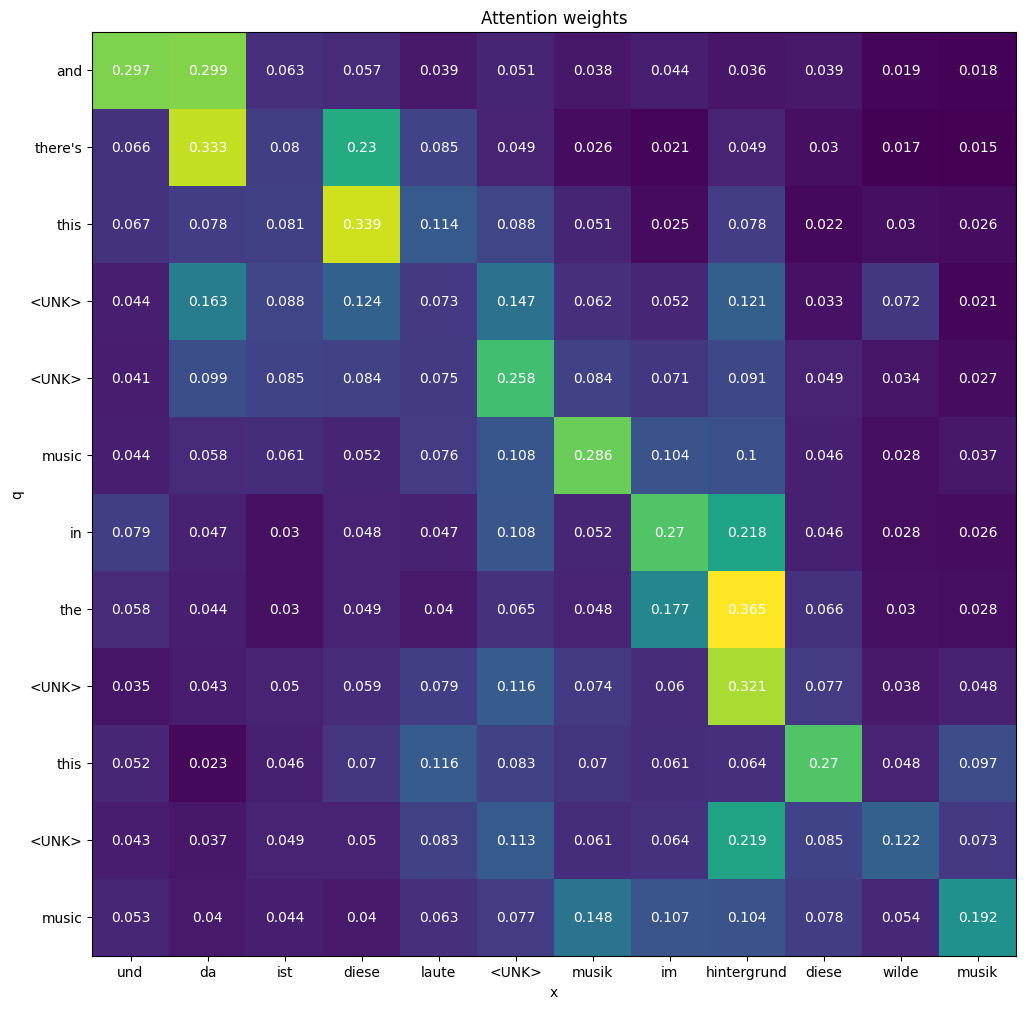

In [ ]:
import matplotlib.colors as colors

attention_weights_numpy = attention_weights.detach().cpu().numpy().squeeze()
if len(attention_weights_numpy.shape) < 2:
  attention_weights_numpy = np.expand_dims(attention_weights_numpy, 0)

# q_numpy = q.numpy().squeeze()
# if len(q_numpy.shape) < 1:
#   q_numpy = np.expand_dims(q_numpy, 0)

count_rows = attention_weights_numpy.shape[0]
count_columns = attention_weights_numpy.shape[1]

cell_size = 1
plt.figure(figsize = (cell_size * count_rows, count_columns * cell_size))
plt.imshow(attention_weights_numpy, extent=[0, count_columns, count_rows, 0])

for i in range(count_rows):
  for j in range(count_columns):
    e = attention_weights_numpy[i][j]
    e = np.round(e, 3)
    plt.annotate(str(e), xy=(j+0.5, i+0.5), ha='center', va='center', color='white')

plt.title("Attention weights")
plt.xlabel("x")
plt.ylabel("q")
plt.xticks(
    ticks=np.arange(0, count_columns) + 0.5,
    labels=[id_to_de[id] for id in val_de_ids]
)
plt.yticks(
    ticks=np.arange(0, count_rows) + 0.5,
    labels=[id_to_en[id] for id in val_en_ids]
)

plt.show()